In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

In [2]:
class AddNormalNoise:
    def __init__(self, mean=0, std=1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.shape) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f"(mean={self.mean}, std={self.std})"

In [3]:
batch_size = 64

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

data_transform = transforms.Compose(data_transforms)
train_set = torchvision.datasets.FashionMNIST("data", download=True, train=True, transform=data_transforms)
test_set = torchvision.datasets.FashionMNIST("data", download=True, train=False, transform=data_transforms)
data = torch.utils.data.ConcatDataset([train_set, test_set])

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

In [2]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super(DownBlock, self).__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

In [3]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, strideT=2, out_paddingT=1):
        super(UpBlock, self).__init__()
        # 2 * in_chs for concatednated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [4]:
class UNet(nn.Module):
    def __init__(self, img_ch, img_size):
        super(UNet, self).__init__()
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = img_size // 4 # 2 ** (len(down_chs) - 1)

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [5]:
unet = UNet(img_ch=1, img_size=16)

In [7]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [17]:
def u_net_visual_explainer(batch_size, img_ch, img_size, fontname="Helvetica"):
    graphviz.set_jupyter_format('png')
    model_graph = draw_graph(
        unet,
        input_size=(batch_size, img_ch, img_size, img_size),
        device='meta',
        expand_nested=True
    )
    model_graph.visual_graph.node_attr["fontname"] = fontname
    model_graph.resize_graph(scale=1.5)
    return model_graph.visual_graph

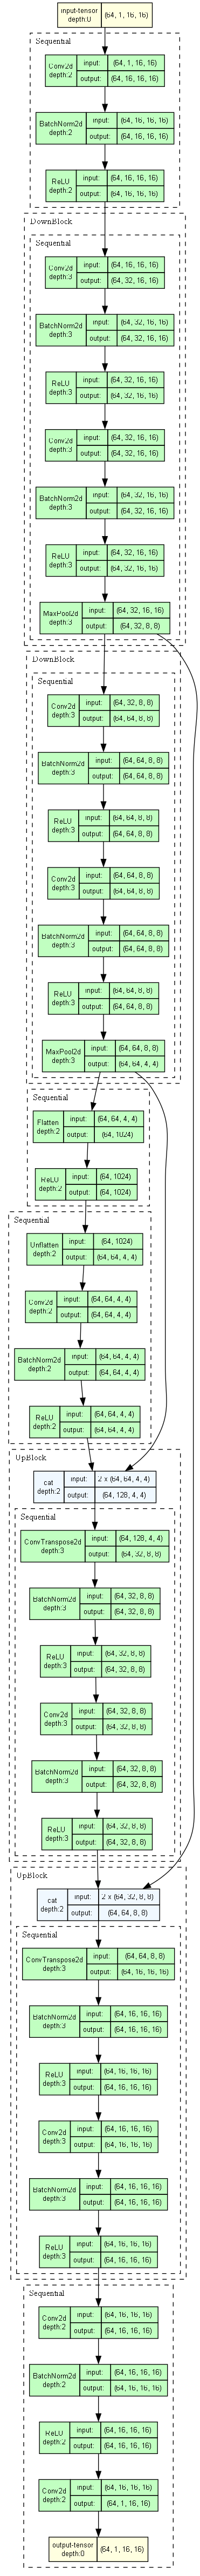

In [18]:
u_net_visual_explainer(64, 1, 16)